<a href="https://colab.research.google.com/github/barbaramedeiros/Kafka/blob/main/Projeto_Kafka_BarbaraM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import os
import sys
import json
import time
import numpy as np
import pandas as pd
import seaborn as sns
from json import loads
import geopandas as gpd
from csv import DictReader
import plotly.express as px
from datetime import datetime
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize


In [2]:
#Checando a versão Java instalada
!java -version

openjdk version "11.0.22" 2024-01-16
OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1)
OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)


In [3]:
#Instalando Java 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [4]:
#Mudando a versão do Java para usar como padrão
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


In [5]:
#Mudando a versão do javac para usar como padrão
!update-alternatives --set javac /usr/lib/jvm/java-8-openjdk-amd64/bin/javac

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/bin/javac to provide /usr/bin/javac (javac) in manual mode


In [6]:
#Mudando a versão do jps para usar como padrão
!update-alternatives --set jps /usr/lib/jvm/java-8-openjdk-amd64/bin/jps

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/bin/jps to provide /usr/bin/jps (jps) in manual mode


In [7]:
#Checando a versão de Java padrão
!java -version

openjdk version "1.8.0_392"
OpenJDK Runtime Environment (build 1.8.0_392-8u392-ga-1~22.04-b08)
OpenJDK 64-Bit Server VM (build 25.392-b08, mixed mode)


In [8]:
#Encontrando o caminho Java padrão
!readlink -f /usr/bin/java | sed "s:bin/java::

/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [9]:
#Criando as variáveis de ambiente
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["JRE_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64/jre"
os.environ["PATH"] += ":$JAVA_HOME/bin:$JRE_HOME/bin:$HADOOP_HOME/bin:$HADOOP_HOME/sbin"

In [10]:
#Instalando o pacote
!pip install kafka-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.5/246.5 kB 1.9 MB/s eta 0:00:00


In [11]:
from kafka import KafkaProducer
from kafka import KafkaConsumer

In [12]:
#Baixar e descompactar o Kafka (5 minutos)
!curl -sSOL https://archive.apache.org/dist/kafka/3.4.0/kafka_2.13-3.4.0.tgz
!tar -xzf kafka_2.13-3.4.0.tgz
#Remover o arquivo compactado
!rm kafka_2.13-3.4.0.tgz

In [13]:
#Copiando os arquivos do kafka para user/local
!cp -r kafka_2.13-3.4.0 /usr/local/

In [14]:
#Verificando os arquivos no diretório bin do Kafka
!ls /usr/local/kafka_2.13-3.4.0/bin

connect-distributed.sh	      kafka-dump-log.sh		     kafka-server-stop.sh
connect-mirror-maker.sh       kafka-features.sh		     kafka-storage.sh
connect-standalone.sh	      kafka-get-offsets.sh	     kafka-streams-application-reset.sh
kafka-acls.sh		      kafka-leader-election.sh	     kafka-topics.sh
kafka-broker-api-versions.sh  kafka-log-dirs.sh		     kafka-transactions.sh
kafka-cluster.sh	      kafka-metadata-quorum.sh	     kafka-verifiable-consumer.sh
kafka-configs.sh	      kafka-metadata-shell.sh	     kafka-verifiable-producer.sh
kafka-console-consumer.sh     kafka-mirror-maker.sh	     trogdor.sh
kafka-console-producer.sh     kafka-producer-perf-test.sh    windows
kafka-consumer-groups.sh      kafka-reassign-partitions.sh   zookeeper-security-migration.sh
kafka-consumer-perf-test.sh   kafka-replica-verification.sh  zookeeper-server-start.sh
kafka-delegation-tokens.sh    kafka-run-class.sh	     zookeeper-server-stop.sh
kafka-delete-records.sh       kafka-server-start.sh	     zookeep

In [15]:
#Verificando os arquivos no diretório config do Kafka
!ls /usr/local/kafka_2.13-3.4.0/config

connect-console-sink.properties    connect-mirror-maker.properties  server.properties
connect-console-source.properties  connect-standalone.properties    tools-log4j.properties
connect-distributed.properties	   consumer.properties		    trogdor.conf
connect-file-sink.properties	   kraft			    zookeeper.properties
connect-file-source.properties	   log4j.properties
connect-log4j.properties	   producer.properties


In [16]:
#Usando as configurações padrão (fornecidas pelo Apache Kafka) para ativar as instâncias do Zookeper e do Kafka.
!./kafka_2.13-3.4.0/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.4.0/config/zookeeper.properties
!./kafka_2.13-3.4.0/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.4.0/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


In [17]:
#Lista de processos
!ps -ef | grep kafka

root        1909     635  0 18:32 ?        00:00:00 /bin/bash -c ps -ef | grep kafka
root        1911    1909  0 18:32 ?        00:00:00 grep kafka


In [18]:
#Criando 1 tópico
!./kafka_2.13-3.4.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic data-topic1

Created topic data-topic1.


In [19]:
#Realizando o download do arquivo brewery

'''
Open Brewery DB é um conjunto de dados e API gratuitos com informações públicas sobre cervejarias, cidrarias, pubs e lojas de bebidas

'''


!wget --quiet --show-progress https://raw.githubusercontent.com/openbrewerydb/openbrewerydb/master/breweries.csv

breweries.csv       100%[===================>]   1.46M  --.-KB/s    in 0.06s   


In [20]:
#Inicializar o cliente Kafka Producer
producer = KafkaProducer(bootstrap_servers=['localhost:9092'])

print(f'Iniciando o Kafka producer at {datetime.utcnow()}')

Iniciando o Kafka producer at 2024-03-08 18:32:45.660074


In [21]:
#Realizando a leitura do arquivo csv, converte para o formato dicionário e envia as mensagens para o
#tópico com o producer
counter = 0
topic_name = 'dados_cervejaria'

sys.set_int_max_str_digits(1000)

with open('/content/breweries.csv','r') as new_obj:
    csv_dict_reader = DictReader(new_obj)
    for row in csv_dict_reader:
      key = str(counter).encode('utf-8')
      ack = producer.send(topic=topic_name, key=key, value=json.dumps(row).encode('utf-8'))
      metadata = ack.get()
      counter = counter + 1
      print(metadata.topic, metadata.partition, key)

producer.flush()
print("Wrote {0} messages into topic: {1}".format(counter, topic_name))

Streaming output truncated to the last 5000 lines.
dados_cervejaria 0 b'3250'
dados_cervejaria 0 b'3251'
dados_cervejaria 0 b'3252'
dados_cervejaria 0 b'3253'
dados_cervejaria 0 b'3254'
dados_cervejaria 0 b'3255'
dados_cervejaria 0 b'3256'
dados_cervejaria 0 b'3257'
dados_cervejaria 0 b'3258'
dados_cervejaria 0 b'3259'
dados_cervejaria 0 b'3260'
dados_cervejaria 0 b'3261'
dados_cervejaria 0 b'3262'
dados_cervejaria 0 b'3263'
dados_cervejaria 0 b'3264'
dados_cervejaria 0 b'3265'
dados_cervejaria 0 b'3266'
dados_cervejaria 0 b'3267'
dados_cervejaria 0 b'3268'
dados_cervejaria 0 b'3269'
dados_cervejaria 0 b'3270'
dados_cervejaria 0 b'3271'
dados_cervejaria 0 b'3272'
dados_cervejaria 0 b'3273'
dados_cervejaria 0 b'3274'
dados_cervejaria 0 b'3275'
dados_cervejaria 0 b'3276'
dados_cervejaria 0 b'3277'
dados_cervejaria 0 b'3278'
dados_cervejaria 0 b'3279'
dados_cervejaria 0 b'3280'
dados_cervejaria 0 b'3281'
dados_cervejaria 0 b'3282'
dados_cervejaria 0 b'3283'
dados_cervejaria 0 b'3284'
dado

In [22]:
#Crie um consumidor todas as mensagens do tópico, mas não marque como 'lidas' (enable_auto_commit=False)
#para que possamos relê-los quantas vezes quisermos.
consumer = KafkaConsumer(topic_name,
                         group_id = 'Topicos',
                         bootstrap_servers=['localhost:9092'],
                         value_deserializer=lambda m: json.loads(m.decode('utf-8')),
                         auto_offset_reset ='earliest',
                         enable_auto_commit=False,
                         consumer_timeout_ms = 10000
                         )

In [23]:
#Ler o consumidor, concatenar todas as linhas, normalizando o json
lista = []

for message in consumer:
    global combined
    data = pd.json_normalize(message.value)
    lista.append(data)

dados = pd.concat(lista)

In [24]:
# Colunas na base de dados, tipos de dados
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8249 entries, 0 to 0
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              8249 non-null   object
 1   name            8249 non-null   object
 2   brewery_type    8249 non-null   object
 3   address_1       8249 non-null   object
 4   address_2       8249 non-null   object
 5   address_3       8249 non-null   object
 6   city            8249 non-null   object
 7   state_province  8249 non-null   object
 8   postal_code     8249 non-null   object
 9   country         8249 non-null   object
 10  phone           8249 non-null   object
 11  website_url     8249 non-null   object
 12  longitude       8249 non-null   object
 13  latitude        8249 non-null   object
dtypes: object(14)
memory usage: 966.7+ KB


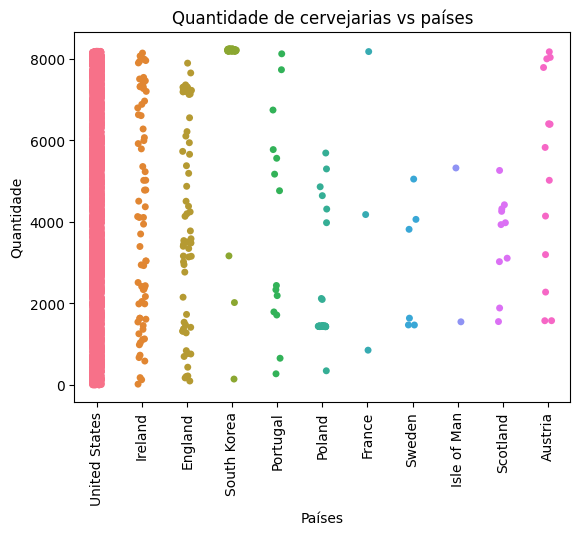

In [25]:
#QUESTAO 1 - Qual é o país com o maior número de cervejarias? Resposta: Estados Unidos
dados['country'] = dados['country'].apply(lambda x: x.strip())
paises = dados['country']
paises = paises.reset_index()

sns.stripplot(paises, x=paises.country, y=paises.index, hue =paises.country)
plt.xticks(rotation=90)
plt.title("Quantidade de cervejarias vs países")
plt.xlabel("Países")
plt.ylabel("Quantidade")
plt.show()

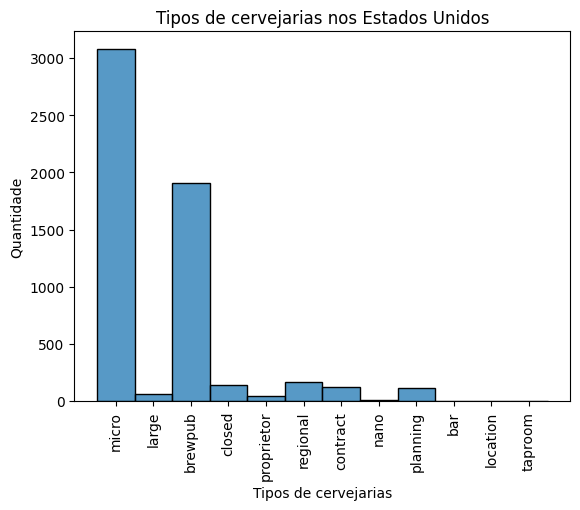

In [26]:
#QUESTAO 2 - Quais são os tipos predominantes de cervejarias nesse país?

dados['longitude'] = dados['longitude'].apply(lambda x: float(x) if x != '' else np.nan)
dados['latitude'] = dados['latitude'].apply(lambda x: float(x) if x != '' else np.nan)

#Filtrando base de dados
dados_us = dados[dados['country'] == "United States"]
dados_us = dados_us.dropna()
dados_us = dados_us[dados_us.latitude > 0]

sns.histplot(data=dados_us, x="brewery_type")
plt.xticks(rotation=90)
plt.title("Tipos de cervejarias nos Estados Unidos")
plt.ylabel("Quantidade")
plt.xlabel("Tipos de cervejarias")
plt.show()

In [27]:
#QUESTAO 3 - Quais são os estados com o maior número de cervejarias no país líder e seus tipos?

dados_us['state_province'].value_counts()

California              908
Washington              433
Oregon                  287
Michigan                270
Colorado                254
New York                231
Ohio                    217
Pennsylvania            193
North Carolina          185
Wisconsin               177
Texas                   169
Florida                 166
Illinois                158
Virginia                134
Missouri                130
Minnesota               124
Massachusetts           100
Iowa                     90
Indiana                  87
Arizona                  76
Tennessee                72
Maine                    66
Idaho                    64
New Jersey               58
Montana                  56
Georgia                  52
New Mexico               52
Nebraska                 51
Alaska                   51
New Hampshire            49
Maryland                 48
Kentucky                 48
Connecticut              46
South Dakota             44
South Carolina           42
Oklahoma            

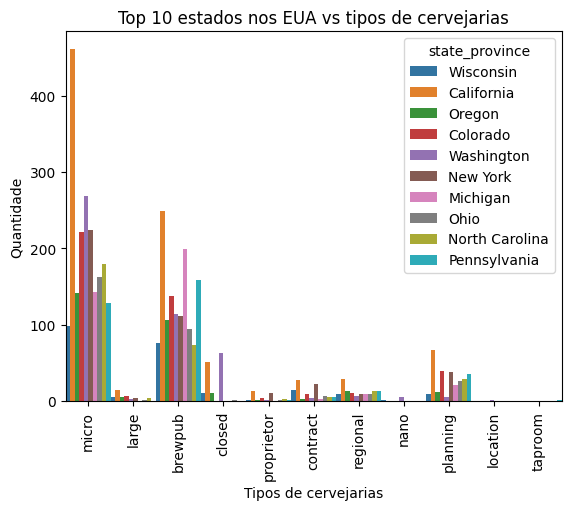

In [28]:
#Filtrando top 10 estados com mais cervejarias
top10 = dados[dados['state_province'].isin(['California', 'Washington', 'Oregon', 'Michigan', 'Colorado', 'New York','Ohio',
                                                    'Pennsylvania','North Carolina','Wisconsin'])]
sns.countplot(data=top10, x="brewery_type", hue="state_province", width=1)
plt.xticks(rotation=90)
plt.title("Top 10 estados nos EUA vs tipos de cervejarias")
plt.ylabel("Quantidade")
plt.xlabel("Tipos de cervejarias")
plt.show()

In [29]:
# QUESTAO 4 - Onde estão localizadas as cervejarias e quais são os tipos predominantes em cada localização?

world = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
fig = px.scatter_geo(dados_us, lon='longitude', lat='latitude', color='brewery_type',
                     hover_name='city', hover_data='state_province',
                     projection="natural earth", scope='north america',
                      template="plotly")
fig.update_geos(showcountries=True, countrycolor="Black",showsubunits=True, subunitcolor="Blue")
fig.update_layout(title='Localização de cervejarias nos Estados Unidos vs tipos de cervejarias', geo=dict(showcoastlines=True, coastlinecolor="Black",),height=600, width=800)
fig.show()



<ipython-input-29-93a19d240efe>:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_cities' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
